#CafChem tools for reading ChEMBL data and performing basic Machine Learning analysis.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/Research_Notebooks/blob/main/BasicML_CafChem.ipynb)

## This notebook allows you to:
- Read in a CSV file directly from ChEMBL and clean it up.
- featurize data, remove outliers, perform scaling and/or PCA. Split data into training and validation sets.
- fit a wide range of models, from tree-based methods, to linear methods, to support vectore regression, to multilayer perceptrons.
- visualize predicted data.
- save CSV files with the clean data.
- save models and/or features as pickle files.

## Requirements:
- This notebook will install deepchem and mordred
- It will pull the CafChem tools from Github.
- It will install all needed libraries.

### install some libraries
- will require a restart

In [1]:
! pip install deepchem
! pip install mordred

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 98.3 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176718 sha256=77f53fd538b513d1b90ad4e845fdf6512b68d22b68725afc907e776d36f68a15
  Stored in directory: /root/.cache/pip/wheels/8b/30/0b/84e3f6775306e74cf5957ee4d16b10bf3927dcec44cc23d5f2
Successfully built mordred
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: networkx
    Found existing 

### Pull CafChem from github and load needed libraries

In [1]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 64 (delta 29), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (64/64), 646.43 KiB | 3.37 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [2]:
import numpy as np
import pandas as pd
import pickle
import CafChem.CafChemBML as ccml

print("All libraries loaded!")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


All libraries loaded!


## Load and process a CSV file from ChEMBL
- assumes the usual column headings and separator from ChEMBL
- cleans data to get only confident IC50 values in nM (this can be changed), converts to canonical smiles and drops duplicates.
- returns a dataframe with only SMILES, IC50 and logIC50.

- function below plots the input IC50 data to view the spread.

In [4]:
df = ccml.process_chembl_csv("/content/MAOB_ChEMBL2.csv")
df.head()

Dataframe created from /content/MAOB_ChEMBL2.csv. Number of unique SMILES: 4015


,SMILES,IC50,logIC50
4,Cn1c(=O)c2c(nc(OCc3ccccc3)n2C)n(C)c1=O,1240.00,3.093422
5,Cn1c(=O)c2c(nc(OCc3cccc(C(F)(F)F)c3)n2C)n(C)c1=O,3720.00,3.570543
8,CCc1ccc(NC(=S)N/N=C/c2ccc(-n3nc4c(c3C)N(C)S(=O...,2910.00,3.463893
16,O=C(CCCc1ccccc1)Nc1nc2cc(Cl)ccc2c(=O)s1,76.40,1.883093
18,O=C(COc1cccc(Cl)c1)Nc1nc2ccccc2c(=O)s1,1.63,0.212188


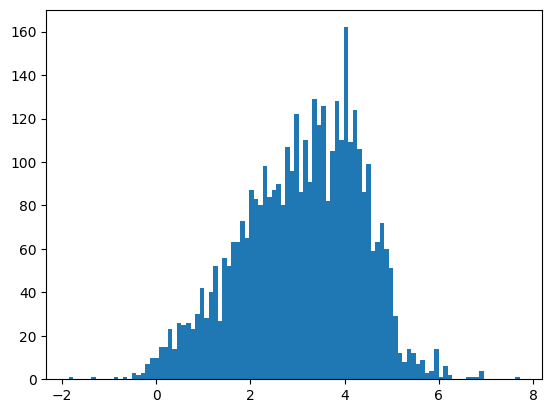

In [5]:
ccml.list_hist(df["logIC50"].to_list(),200)

## Featurize data
- featurize with either circular fingerprints, rdkit descriptors or
mordred descriptors (these take a while!)
- Checks to NaNs and removes them.
- returns features array, target array, and smiles array with NaNs removed

In [6]:
f, y, smiles = ccml.featurize(df["SMILES"].to_list(), df["logIC50"].to_list(), featurizer="rdkit")

Row 921 has a NaN.
Row 3920 has a NaN.
Row 3921 has a NaN.
Row 3922 has a NaN.
Row 3923 has a NaN.
Row 3924 has a NaN.
Row 3959 has a NaN.
Old dimensions are: (4015, 217).
Deleting row 921 from arrays.
Deleting row 3919 from arrays.
Deleting row 3919 from arrays.
Deleting row 3919 from arrays.
Deleting row 3919 from arrays.
Deleting row 3919 from arrays.
Deleting row 3953 from arrays.
New dimensions are: (4008, 217)


## Remove outliers from the data
- returns feature array, target array, and SMILES array without outliers.

In [7]:
f, y, smiles = ccml.remove_outliers(f, y, smiles)

/usr/local/lib/python3.11/dist-packages/sklearn/covariance/_robust_covariance.py:749: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


Outliers found in the following locations: (array([  31,  146,  337,  388,  422,  437,  485,  507,  578,  588,  886,
       1012, 1244, 1351, 1551, 1552, 1553, 1957, 1979, 1994, 2167, 2346,
       2395, 2456, 2467, 2489, 2726, 2832, 2964, 3038, 3056, 3057, 3234,
       3253, 3318, 3319, 3414, 3495, 3498, 3826, 3976]),)
Starting outlier removal.
Deleting row 31 from dataset
Deleting row 145 from dataset
Deleting row 335 from dataset
Deleting row 385 from dataset
Deleting row 418 from dataset
Deleting row 432 from dataset
Deleting row 479 from dataset
Deleting row 500 from dataset
Deleting row 570 from dataset
Deleting row 579 from dataset
Deleting row 876 from dataset
Deleting row 1001 from dataset
Deleting row 1232 from dataset
Deleting row 1338 from dataset
Deleting row 1537 from dataset
Deleting row 1537 from dataset
Deleting row 1537 from dataset
Deleting row 1940 from dataset
Deleting row 1961 from dataset
Deleting row 1975 from dataset
Deleting row 2147 from dataset
Deleting row 2

## Prepare data for modelling
 - can opt to scale data
 - can opt to perform PCA
 - split into training and vaidation sets at a chosen percentage

In [8]:
x_train, x_valid, y_train, y_valid, smiles_train, smiles_valid =  ccml.scale_pca_split(f, y, smiles, use_scaler = True,
                    use_pca = False, pca_size = 100, seed = 42, splits = 0.9)

Pre-processing done.


## Perform modelling
- choose from tree regression methods (decision tree, random forest, or gradient boosting).
- choose from linear regression methods (linear, ridge and lasso) or support vector regression.
- choose a multilayer perceptron.
- perform k-means analysis
- hyperparameters are optional. Hover over to see what may be changed

In [10]:
rf = ccml.tree_regression(method="forest")
tree_model = rf.fit(x_train, x_valid, y_train, y_valid)

Tree regression class initialized.
model selected:  RandomForest
fit model in: 0.6101417133999992 minutes
score for training set:  0.9370017337782672
score for validation set:  0.5711834686781456


In [12]:
lin = ccml.linear_svr_methods(method="svr")
svr_model = lin.fit(x_train, x_valid, y_train, y_valid)

Linear SVR class initialized.
model selected:  Support Vector Regression
fit model in: 0.08514053795000033 minutes
score for training set:  0.8049112225085883
score for validation set:  0.4861584694432536


In [13]:
mlp = ccml.mlp_methods(max_iter=5000)
mlp_model = mlp.fit(x_train, x_valid, y_train, y_valid)

MLP class initialized.
model selected:  MultiLayerPerceptron
fit model in: 2.136275591983334 minutes
score for training set:  0.9618183200321645
score for validation set:  -0.03810664067559433


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [14]:
kmeans_model, train_labels, valid_labels = ccml.kmeans(x_train, x_valid, number_groups=10)

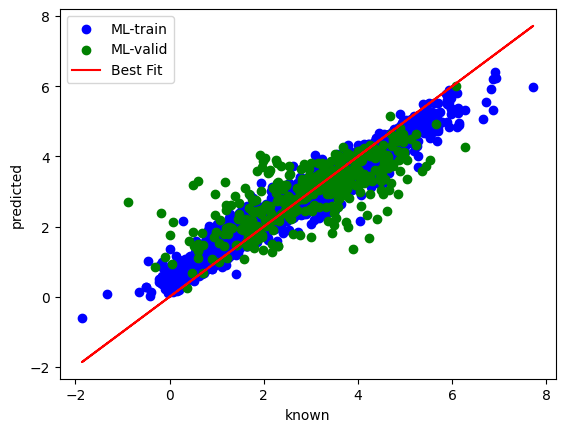

In [15]:
ccml.plot_predictions(tree_model, x_train, y_train, x_valid, y_valid)

## Save modes, CSV files, features

In [16]:
with open('maob_forest_model.pkl','wb') as model_file:
  pickle.dump(tree_model, model_file)

In [17]:
y_to_save = np.concatenate((y_train,y_valid))
y_to_save = 10**y_to_save

predictions = tree_model.predict(f)
predictions = 10**predictions

smiles_to_save = np.concatenate((smiles_train,smiles_valid))


ccml.save_csv(smiles_to_save, y_to_save, predictions, "maob_forest_predictions")

,smiles,known,predicted
0,C#CCN1CCN(CN2C(=O)S/C(=C/c3ccc(OCc4ccccc4)cc3)...,5730.0,1465.576007
1,C[C@H](Cc1ccc(OCc2ccncc2)cc1)N(C)CC(=O)O,22044.0,1373.180440
2,C#CCNC1CCc2c(SCc3ccc(Cl)cc3)cccc21,180.0,1230.162032
3,O=C1OCc2ccc(OCc3ccc(F)cc3)cc21,6.4,2184.994038
4,N#Cc1c(F)c(F)c(NC(=O)c2cc3ccc(OCc4ccc(F)cc4)cc...,3450.0,1080.779747
...,...,...,...
3962,CN(C)C(=O)Oc1cccc(/C=C/C(=O)c2ccccc2OC(=O)N(C)...,2900.0,1956.399559
3963,O=C(Nc1ccc(Cl)c(O)c1)c1ccc2cn[nH]c2c1,6220.0,1447.613779
3964,COc1ccc(/C=C2\COc3cc(OCCCCCCNc4c5c(nc6ccccc46)...,19730.0,1317.275791
3965,Cc1cccc2cc(-c3ccccc3)oc12,10730.0,1885.810463


In [18]:
feats_to_save = np.concatenate((x_train,x_valid))
ccml.save_features(feats_to_save, "maob_rdkit_features")

Features saved to maob_rdkit_features.pkl
